# PROJET 4 : Anticipez les besoins en consommation électrique de bâtiments

# SOMMAIRE
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [CHARGEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
## [1. ANALYSE DE LA QUALITE DES DONNEES](#5)<a class="anchor" id="sommaire"></a>
## [2. FUSION DES DONNEES](#6)<a class="anchor" id="sommaire"></a>
## [3. CORRECTION DES DONNEES](#7)<a class="anchor" id="sommaire"></a>
## [4. SUPPRESSION DES DONNEES EN ERREUR](#8)<a class="anchor" id="sommaire"></a>
## [5. ANALYSE DES CORRELATIONS POUR SELECTION DES VARIABLES](#9)<a class="anchor" id="sommaire"></a>
## [6. FINALISATION DATASET NETTOYER](#10)<a class="anchor" id="sommaire"></a>

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Les données de consommation sont à télécharger à cette adresse.

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer, normalize
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn , KNeighborsRegressor as knr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from functions import *
from math import radians
import json

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999


In [2]:
def nth_repl(s, sub, repl, n):
    a = []
    find = s.find(sub)
    # If find is not -1 we have found at least one match for the substring
    i = find != -1
    a.append(i)
    # loop util we find the nth or we find no match
    while find != -1 :
        # find + 1 means we start searching from after the last match
        find = s.find(sub, find + 1)
        a.append(find)
        i += 1
    # If i is equal to n we found nth match so replace
    for j in n :
        if j > len(a) :
            continue
        else :
            s = s[:a[j]] + repl + s[a[j]+1:]
    return s

## [CHARGEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

In [3]:
raw_data2015 = pd.read_csv("DATA/2015-building-energy-benchmarking.csv")
raw_data2016 = pd.read_csv("DATA/2016-building-energy-benchmarking.csv")

## [ANALYSE DE LA QUALITE DES DONNEES](#sommaire)<a class="anchor" id="6"></a>

In [4]:
raw_data2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      3340 non-null   int64  
 1   DataYear                           3340 non-null   int64  
 2   BuildingType                       3340 non-null   object 
 3   PrimaryPropertyType                3340 non-null   object 
 4   PropertyName                       3340 non-null   object 
 5   TaxParcelIdentificationNumber      3338 non-null   object 
 6   Location                           3340 non-null   object 
 7   CouncilDistrictCode                3340 non-null   int64  
 8   Neighborhood                       3340 non-null   object 
 9   YearBuilt                          3340 non-null   int64  
 10  NumberofBuildings                  3340 non-null   int64  
 11  NumberofFloors                     3332 non-null   float

In [5]:
raw_data2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

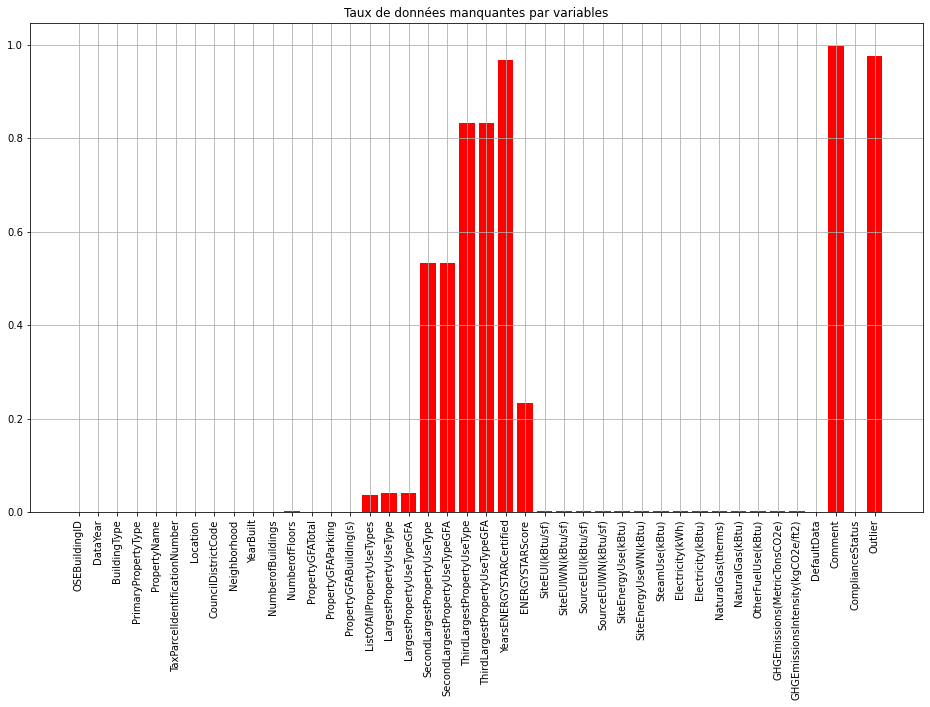

In [6]:
isna_data = raw_data2015.isna().mean()
plt.figure(figsize=(16,9))
plt.grid()
plt.xticks(rotation=90)
plt.bar(x = isna_data.index, height = isna_data.values, color = "red")
plt.title("Taux de données manquantes par variables")

plt.show()

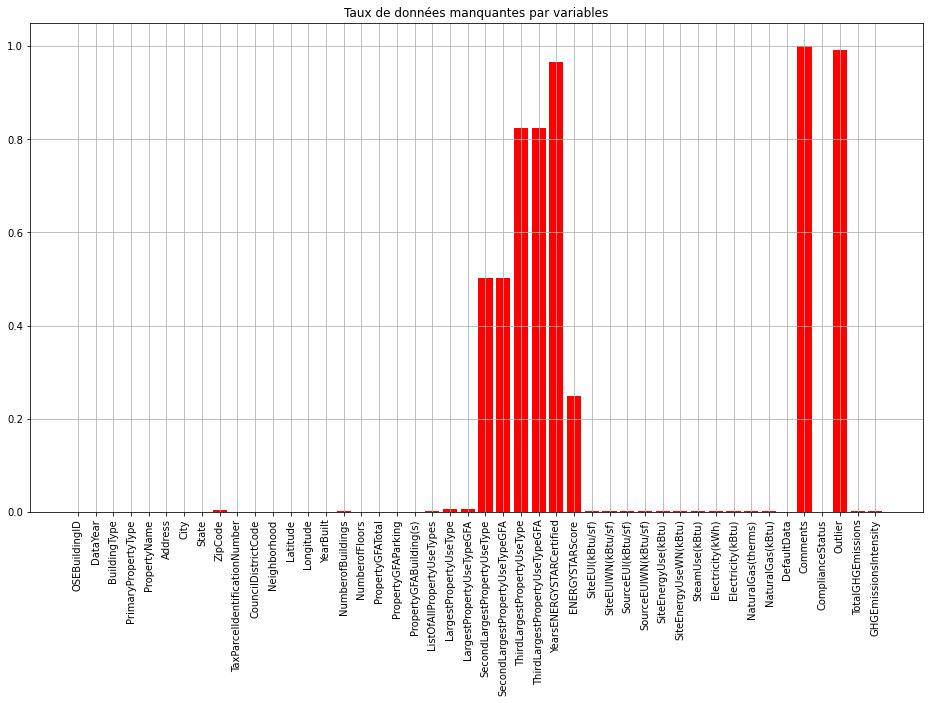

In [7]:
isna_data = raw_data2016.isna().mean()
plt.figure(figsize=(16,9))
plt.grid()
plt.xticks(rotation=90)
plt.bar(x = isna_data.index, height = isna_data.values, color = "red")
plt.title("Taux de données manquantes par variables")

plt.show()

## [FUSION DES DONNEES](#sommaire)<a class="anchor" id="7"></a>

In [8]:
col_2015 = pd.DataFrame(data = raw_data2015.columns, columns=["variables"])
col_2016 = pd.DataFrame(data = raw_data2016.columns, columns=["variables"])

merge_error = pd.merge(col_2015, col_2016, left_on="variables", right_on="variables", how="outer", indicator=True)


d = {"left_only":"2015", "right_only":"2016", "both":"both"}

merge_error["_merge"] = merge_error["_merge"].map(d)
merge_error = merge_error[merge_error["_merge"] != "both"] 
merge_error

,variables,_merge
6,Location,2015
35,OtherFuelUse(kBtu),2015
36,GHGEmissions(MetricTonsCO2e),2015
37,GHGEmissionsIntensity(kgCO2e/ft2),2015
39,Comment,2015
42,Address,2016
43,City,2016
44,State,2016
45,ZipCode,2016
46,Latitude,2016


<p>On remarque plusieurs colonnes qui semblent différentes entre les deux années. Nous n'étudirons pas les colonnes : "comment" et "comments", car comme vu dans l'études das valeurs manquantes, il n'y a aucunes données dans ces colonnes, nous les supprimerons. Nous avons aussi vu que les données outliers sont vides, nous les supprimerons aussi.</p>
<p>On remarque que sur 2015 nous n'avons qu'une seul colonne localisation, alors que 2016 en totalise 6, nous allons sûrement devoir splitter l'unique colonne de 2015. Nous remarquons aussi que les colonnes des émissions de CO2 portent le même début de nom, seulement l'unité est inscrite sur 2015 et pas sur 2016, il faut vérifier que malgré cela les unités sont les mêmes.</p>

In [9]:
raw_data2015 = raw_data2015.drop("Comment", axis = 1)
raw_data2016 = raw_data2016.drop("Comments", axis = 1)
raw_data2015 = raw_data2015.drop("Outlier", axis = 1)
raw_data2016 = raw_data2016.drop("Outlier", axis = 1)

In [10]:
raw_data2015.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,1559.000000,560.000000,2560.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,27675.646568,10755.708929,67.894141,53.626126,57.586547,132.779730,138.936036,4.983106e+06,5.203055e+06,2.502851e+05,1.017897e+06,3.473209e+06,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,52480.843425,22618.529737,27.154057,53.893311,55.604963,131.943223,131.359121,1.375330e+07,1.400757e+07,3.481900e+06,2.789931e+06,9.519639e+06,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,4959.000000,2385.250000,51.750000,27.300000,29.700000,73.500000,80.300000,9.139300e+05,9.883248e+05,0.000000e+00,1.864908e+05,6.363322e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,10600.000000,5019.500000,76.000000,37.400000,40.900000,95.000000,102.800000,1.776219e+06,1.953996e+06,0.000000e+00,3.400320e+05,1.160236e+06,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,26224.500000,10275.000000,90.000000,59.875000,65.575000,143.900000,151.275000,4.044277e+06,4.368462e+06,0.000000e+00,8.061935e+05,2.750847e+06,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,686750.000000,303910.000000,100.000000,800.600000,800.600000,2511.100000,2511.000000,2.958126e+08,2.977410e+08,1.278697e+08,8.344505e+07,2.847263e+08,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000


In [11]:
raw_data2016.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


Au vu des ordres de grandeurs des colonnes : "GHGEmissions(MetricTonsCO2e)", "TotalGHGEmissions", "GHGEmissionsIntensity(kgCO2e/ft2)" et "GHGEmissionsIntensity". On peut en déduire qu'elles se correspondent 2 par 2. Nous renommons les colonnes de 2016 pour correspondre.

In [12]:
raw_data2016 = raw_data2016.rename(columns={"TotalGHGEmissions":"GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity":"GHGEmissionsIntensity(kgCO2e/ft2)"})

In [13]:
raw_data2015.Location = raw_data2015.Location.apply(lambda x: eval(x, {}))

In [14]:
raw_data2015["Address"] = raw_data2015.Location.apply(lambda x: eval(x['human_address'])["address"])
raw_data2015["City"] = raw_data2015.Location.apply(lambda x: eval(x['human_address'])["city"])
raw_data2015["State"] = raw_data2015.Location.apply(lambda x: eval(x['human_address'])["state"])
raw_data2015["ZipCode"] = raw_data2015.Location.apply(lambda x: eval(x['human_address'])["zip"])
raw_data2015["Latitude"] = raw_data2015.Location.apply(lambda x: x['latitude'])
raw_data2015["Longitude"] = raw_data2015.Location.apply(lambda x: x['longitude'])

In [15]:
raw_data2015 = raw_data2015.drop("Location", axis=1)

On a réussi à déplier la colonne location de 2015 pour se réalignier sur les colonnes de localisation de 2016

In [16]:
raw_data2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      3340 non-null   int64  
 1   DataYear                           3340 non-null   int64  
 2   BuildingType                       3340 non-null   object 
 3   PrimaryPropertyType                3340 non-null   object 
 4   PropertyName                       3340 non-null   object 
 5   TaxParcelIdentificationNumber      3338 non-null   object 
 6   CouncilDistrictCode                3340 non-null   int64  
 7   Neighborhood                       3340 non-null   object 
 8   YearBuilt                          3340 non-null   int64  
 9   NumberofBuildings                  3340 non-null   int64  
 10  NumberofFloors                     3332 non-null   float64
 11  PropertyGFATotal                   3340 non-null   int64

In [17]:
raw_data2015 = raw_data2015.astype({"DefaultData":bool, "ZipCode":float, "Latitude":float, "Longitude":float})

On redonne le bon type aux nouvelles colonnes

In [18]:
raw_data2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      3376 non-null   int64  
 1   DataYear                           3376 non-null   int64  
 2   BuildingType                       3376 non-null   object 
 3   PrimaryPropertyType                3376 non-null   object 
 4   PropertyName                       3376 non-null   object 
 5   Address                            3376 non-null   object 
 6   City                               3376 non-null   object 
 7   State                              3376 non-null   object 
 8   ZipCode                            3360 non-null   float64
 9   TaxParcelIdentificationNumber      3376 non-null   object 
 10  CouncilDistrictCode                3376 non-null   int64  
 11  Neighborhood                       3376 non-null   objec

In [19]:
raw_data = pd.merge(raw_data2015, raw_data2016, how='outer').sort_values(["OSEBuildingID", "DataYear"])

On fusionne les deux années en triant sur l'ID des constructions et en ordonnant par l'année pour pouvoir ensuite supprimer les doublons en ne gardant que les données les plus récentes.

## [CORRECTION DES DONNEES](#sommaire)<a class="anchor" id="7"></a>

In [20]:
a = raw_data['Electricity(kBtu)'].fillna(0) + raw_data['NaturalGas(kBtu)'].fillna(0) +\
raw_data['SteamUse(kBtu)'].fillna(0) + raw_data['OtherFuelUse(kBtu)'].fillna(0)
b = raw_data['SiteEnergyUse(kBtu)'].fillna(0)

raw_data["Sum_energy"] = abs(np.where(a==0, np.nan, a) - np.where(b==0, np.nan, b))
raw_data = raw_data.dropna(subset = ["Sum_energy"], axis=0)
raw_data = raw_data.sort_values(["OSEBuildingID", "Sum_energy"])

In [21]:
mask = raw_data.duplicated(["OSEBuildingID"], keep=False)

On rempli les données manquantes si il y en a pour les constructions qui existent dans les deux années.

In [22]:
raw_data = raw_data.drop_duplicates(["OSEBuildingID"],keep="first")

In [23]:
raw_data = raw_data.drop("Sum_energy", axis =1)

On supprime les doublons des bâtiments présents sur les deux années en ne conservant que les données de 2016

In [24]:
mask = raw_data["SiteEnergyUse(kBtu)"] == 0
raw_data.loc[mask, "SiteEnergyUse(kBtu)"] = raw_data.loc[mask, "SteamUse(kBtu)"] + raw_data.loc[mask, "Electricity(kBtu)"]\
                                            + raw_data.loc[mask, "NaturalGas(kBtu)"]+ raw_data.loc[mask, "OtherFuelUse(kBtu)"]

On corrige les bâtiments qui n'ont pas de valeur pour la variable "SiteEnergyUse(kBtu)" qui n'est en fait que la somme des variables : SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), OtherFuelUse(kBtu)

In [25]:
raw_data["OtherFuelUse(kBtu)"] = raw_data["SiteEnergyUse(kBtu)"] - (raw_data["SteamUse(kBtu)"] + raw_data["Electricity(kBtu)"] + raw_data["NaturalGas(kBtu)"])

On refait la colonne OtherFuelUse en soustraiant à la varaible SiteEnergyUse(kBtu) toutes les autres variables qui la constitue

## [SUPPRESSION DES DONNEES EN ERREUR](#sommaire)<a class="anchor" id="8"></a>

In [26]:
mask = (raw_data["OtherFuelUse(kBtu)"] >=-100) & (raw_data["OtherFuelUse(kBtu)"] <0)
raw_data.loc[mask, "SiteEnergyUse(kBtu)"] = raw_data.loc[mask, "SiteEnergyUse(kBtu)"] + raw_data["OtherFuelUse(kBtu)"]
raw_data.loc[mask, "OtherFuelUse(kBtu)"] = 0

On corrige sur OtherFuelUse(kBtu) les valeurs proches inférieures à 0, mais supérieures à -1 pour les remettre à 0.

In [27]:
raw_data[raw_data["OtherFuelUse(kBtu)"] <0].shape

(24, 45)

In [28]:
raw_data[raw_data["OtherFuelUse(kBtu)"] <0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude
204,325,2015,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,659000005,7,DOWNTOWN,1989,1.0,4.0,111077,0,111077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,60.600000,62.100000,190.200000,195.100000,9.898724e+06,10155788.0,0.0,2.901150e+06,9899135.0,0.00000,0.0,-411.00,69.01,0.24,True,Compliant,400 PINE ST,SEATTLE,WA,98101.0,47.611711,-122.336816
207,328,2015,NonResidential,Large Office,CENTURYLINK: SEATTLE BELL PLAZA,659000165,7,DOWNTOWN,1976,1.0,33.0,791396,0,791396,"Office, Other, Parking, Restaurant",Office,637099.0,Parking,132465.0,Other,33110.0,2015,89.0,59.800000,0.000000,187.700000,0.000000,4.045175e+07,0.0,0.0,1.185573e+07,40453430.0,0.00000,0.0,-1682.00,282.01,0.14,True,Compliant,1600 7TH AVE,SEATTLE,WA,98101.0,47.613239,-122.334404
272,400,2015,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1974700175,7,DOWNTOWN,1906,1.0,6.0,98370,25920,72450,Office,Office,98370.0,NaN,NaN,NaN,NaN,NaN,45.0,66.300000,66.500000,207.500000,207.700000,6.525887e+06,6541579.0,0.0,1.901522e+06,6488262.0,379.00000,37893.0,-268.00,47.24,0.20,True,Compliant,1201 2ND AVE,SEATTLE,WA,98101.0,47.606799,-122.337100
305,435,2015,NonResidential,Other,WASHINGTON STATE CONVENTION CENTER,1978200105,7,DOWNTOWN,1990,1.0,6.0,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,Parking,686750.0,NaN,NaN,NaN,NaN,72.000000,73.700000,192.500000,191.300000,7.716457e+07,79041984.0,16811018.0,1.720871e+07,58718556.0,16374.00000,1637420.0,-2426.00,1793.90,1.10,True,Compliant,800 CONVENTION PL,SEATTLE,WA,98101.0,47.611586,-122.331601
312,442,2015,NonResidential,Large Office,KING BROADCASTING,1991200870,7,LAKE UNION,1947,1.0,4.0,193788,37854,155934,"Data Center, Office, Other, Parking, Restaurant",Office,138672.0,Parking,47539.0,Other,11166.0,NaN,59.0,105.800000,104.000000,332.300000,326.400000,1.676022e+07,16463978.0,0.0,4.912139e+06,16760914.0,0.00000,0.0,-697.00,116.84,0.23,True,Compliant,333 DEXTER AVE N,SEATTLE,WA,98109.0,47.621476,-122.343050
405,559,2015,NonResidential,Large Office,YALE & THOMAS,6847700105,7,LAKE UNION,1981,1.0,4.0,186971,0,186971,"Office, Parking",Office,186977.0,Parking,115477.0,NaN,NaN,NaN,86.0,67.700000,72.600000,179.100000,184.200000,1.266246e+07,13575377.0,0.0,2.830466e+06,9657951.0,30049.00000,3004906.0,-401.00,226.92,0.99,True,Compliant,325 EASTLAKE AVE E,SEATTLE,WA,98109.0,47.621243,-122.329786
407,561,2015,NonResidential,Large Office,ALLEY 24 EAST,6849700145,7,LAKE UNION,2005,1.0,6.0,336700,124800,211900,"Office, Parking, Retail Store",Office,193420.0,Parking,124620.0,Retail Store,6180.0,NaN,94.0,48.600000,48.600000,152.600000,152.600000,9.697866e+06,9697866.0,0.0,2.842282e+06,9698269.0,0.00000,0.0,-403.00,67.61,0.08,True,Compliant,209 YALE AVE N,SEATTLE,WA,98109.0,47.619855,-122.330481
498,675,2015,NonResidential,Medical Office,NINTH & JEFFERSON BLDG - HARBORVIEW,8590400545,3,EAST,2008,1.0,15.0,434475,250000,184475,"Medical Office, Parking",Medical Office,434475.0,Parking,250000.0,NaN,NaN,2011,60.0,126.700000,130.400000,302.000000,306.500000,5.503019e+07,56652364.0,21474092.0,9.834730e+06,33557492.0,0.00000,0.0,-1392.00,1891.47,4.02,True,Compliant,908 JEFFERSON ST,SEATTLE,

Malgré ces corrections, il reste 24 lignes en erreur que nous allons supprimer.

In [29]:
raw_data = raw_data[raw_data["OtherFuelUse(kBtu)"] >= 0]

In [30]:
raw_data.shape

(3403, 45)

Suite à la suppression il reste 3403 lignes

In [31]:
mask = (raw_data["Electricity(kBtu)"]<=100) | (raw_data["NaturalGas(kBtu)"]<0) | (raw_data["SteamUse(kBtu)"]<0)
raw_data[mask]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude
1689,23064,2015,NonResidential,Other,EVERGREEN-WASHELLI,3026049008,5,NORTHWEST,1970,1.0,1.0,23166,0,23166,Other,Other,23166.0,NaN,NaN,NaN,NaN,NaN,NaN,142.200000,142.200000,149.300000,149.300000,3294645.0,3294645.0,0.0,3.0,11.0,32946.0000,3294634.0,0.0,174.98,7.55,True,Compliant,11111 AURORA AVE N,SEATTLE,WA,98133.0,47.709696,-122.34566
5263,23854,2016,NonResidential,Restaurant,Pier 57,7666202435,7,DOWNTOWN,1900,1.0,1.0,43728,0,43728,Restaurant,Restaurant,43728.0,NaN,NaN,NaN,NaN,NaN,NaN,263.200012,271.100006,276.299988,284.600006,11508035.0,11854450.0,0.0,0.0,0.0,115080.3516,11508035.0,0.0,611.19,13.98,False,Compliant,1301 Alaskan Way,Seattle,WA,98101.0,47.606130,-122.34115


Nous avons deux lignes sans consommation électrique ou très faible, mais avec consommation de gaz, c'est impossible qu'ils ne consomment aucune électricité. Nous les supprimons.

In [32]:
raw_data = raw_data[~mask]

In [33]:
raw_data.shape

(3401, 45)

Nous passons à 3401 lignes.

In [34]:
raw_data.groupby("ComplianceStatus").count()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Address,City,State,ZipCode,Latitude,Longitude
ComplianceStatus,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Compliant,3264,3264,3264,3264,3264,3263,3264,3264,3264,3264,3263,3264,3264,3264,3245,3234,3234,1651,1651,580,580,115,2441,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3264,3251,3264,3264
Error - Correct Default Data,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,15,15,6,6,0,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,108,111,111
Non-Compliant,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,13,13,7,7,0,19,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26


In [35]:
raw_data[raw_data["ComplianceStatus"] == "Error - Correct Default Data"]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude
3362,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,1102000138,2,SOUTHEAST,1961,1.0,2.0,56228,0,56228,K-12 School,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,64.599998,1.539478e+06,1.713624e+06,0.0000,2.746059e+05,9.369550e+05,6025.229004,6.025230e+05,0.5000,38.53,0.69,True,Error - Correct Default Data,5149 S. Graham St.,Seattle,WA,98118.0,47.545760,-122.268530
3370,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,0752000170,5,NORTH,1949,1.0,2.0,160645,0,160645,K-12 School,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,75.699997,6.779173e+06,7.800350e+06,0.0000,5.708092e+05,1.947601e+06,48315.718750,4.831572e+06,0.0000,270.18,1.68,True,Error - Correct Default Data,11051 34th Ave. N.E.,Seattle,WA,98125.0,47.709940,-122.293010
3378,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,0425049022,4,NORTHEAST,1950,1.0,2.0,175565,0,175565,K-12 School,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,60.400002,6.399128e+06,7.329818e+06,0.0000,4.688405e+05,1.599684e+06,47994.433590,4.799443e+06,0.5000,266.05,1.52,True,Error - Correct Default Data,3003 N.E. 75th St.,Seattle,WA,98115.0,47.682520,-122.294980
3426,125,2016,SPS-District K-12,K-12 School,Mercer International Middle,1624049214,2,GREATER DUWAMISH,1957,1.0,1.0,130862,0,130862,K-12 School,K-12 School,134446.0,NaN,NaN,NaN,NaN,NaN,61.0,48.000000,54.299999,85.599998,93.500000,6.456025e+06,7.300978e+06,0.0000,6.631945e+05,2.262820e+06,41932.066410,4.193207e+06,0.0000,238.48,1.82,True,Error - Correct Default Data,1600 Columbian Way S.,Seattle,WA,98108.0,47.564130,-122.312080
3427,127,2016,SPS-District K-12,K-12 School,Orca K-8 School,1704900242,2,SOUTHEAST,1989,1.0,3.0,59955,0,59955,K-12 School,K-12 School,59955.0,NaN,NaN,NaN,NaN,NaN,93.0,27.200001,29.200001,78.699997,83.000000,1.633399e+06,1.749171e+06,0.0000,4.209894e+05,1.436416e+06,1969.832520,1.969830e+05,0.3750,20.48,0.34,True,Error - Correct Default Data,5215 46th Ave. S.,Seattle,WA,98118.0,47.554780,-122.275960
3428,130,2016,SPS-District K-12,K-12 School,McClure Middle,1794501220,7,MAGNOLIA / QUEEN ANNE,1964,1.0,2.0,93218,0,93218,K-12 School,K-12 School,93218.0,NaN,NaN,NaN,NaN,NaN,86.0,31.000000,34.500000,65.900002,70.800003,2.887392e+06,3.216155e+06,0.0000,4.357438e+05,1.486758e+06,14006.339840,1.400634e+06,0.0000,84.75,0.91,True,Error - Correct Default Data,1915 1st Ave. W.,Seattle,WA,98119.0,47.636830,-122.358960
3432,137,2016,SPS-District K-12,K-12 School,Broadview-Thomson K-8,1926049025,5,NORTHWEST,1963,1.0,2.0,131013,0,131013,K-12 School,K-12 School,131909.0,NaN,NaN,NaN,NaN,NaN,88.0,29.500000,32.500000,59.099998,62.900002,3.894584e+06,4.290832e+06,0.0000,5.203657e+05,1.775488e+06,21190.966800,2.119097e+06,0.0000,124.92,0.95,True,Error - Correct Default Data,13052 Greenwood Ave. N.,Seattle,WA,98133.0,47.724630,-122.353150
3439,148,2016,SPS-District K-12,K-12 School,West Woodland Elementary,2768000375,6,Ballard,1991,1.0,2.0,55513,0,55513,K-12 School,K-12 School,59097.0,NaN,NaN,NaN,NaN,NaN,93.0,25.600000,27.100000,80.400002,85.000000,1.513570e+06,1.598853e+06,0.0000,4.436022e+05,1.513571e+06,0.00000

In [36]:
raw_data = raw_data[(raw_data["ComplianceStatus"] == "Error - Correct Default Data") | (raw_data["ComplianceStatus"] == "Compliant")]

On supprime les statuts : "Missing Data" et "Non-compliant"

In [37]:
raw_data.columns = ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI_kBtu_sf', 'SiteEUIWN_kBtu_sf',
       'SourceEUI_kBtu_sf', 'SourceEUIWN_kBtu_sf', 'SiteEnergyUse_kBtu',
       'SiteEnergyUseWN_kBtu', 'SteamUse_kBtu', 'Electricity_kWh',
       'Electricity_kBtu', 'NaturalGas_therms', 'NaturalGas_kBtu',
       'OtherFuelUse_kBtu', 'GHGEmissions_MetricTonsCO2e',
       'GHGEmissionsIntensity_kgCO2e_ft2', 'DefaultData', 'ComplianceStatus',
        'Address', 'City', 'State', 'ZipCode', 'Latitude',
       'Longitude']

In [38]:
raw_data.describe(include='all')

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI_kBtu_sf,SiteEUIWN_kBtu_sf,SourceEUI_kBtu_sf,SourceEUIWN_kBtu_sf,SiteEnergyUse_kBtu,SiteEnergyUseWN_kBtu,SteamUse_kBtu,Electricity_kWh,Electricity_kBtu,NaturalGas_therms,NaturalGas_kBtu,OtherFuelUse_kBtu,GHGEmissions_MetricTonsCO2e,GHGEmissionsIntensity_kgCO2e_ft2,DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude
count,3375.000000,3375.000000,3375,3375,3375,3374,3375.000000,3375,3375.000000,3375.000000,3374.000000,3.375000e+03,3375.000000,3.375000e+03,3356,3345,3.345000e+03,1666,1666.000000,586,586.000000,115,2552.000000,3375.000000,3375.000000,3375.000000,3375.000000,3.375000e+03,3.375000e+03,3.375000e+03,3.375000e+03,3.375000e+03,3.375000e+03,3.375000e+03,3.375000e+03,3375.000000,3375.000000,3375,3375,3375,3375,3375,3359.000000,3375.000000,3375.000000
unique,NaN,NaN,8,26,3361,3267,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,463,56,NaN,50,NaN,44,NaN,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,3353,2,1,NaN,NaN,NaN
top,NaN,NaN,NonResidential,Low-Rise Multifamily,Northgate Plaza,1625049001,NaN,DOWNTOWN,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,NaN,Parking,NaN,Retail Store,NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Compliant,2600 SW Barton St,Seattle,WA,NaN,NaN,NaN
freq,NaN,NaN,1462,993,3,8,NaN,570,NaN,NaN,NaN,NaN,NaN,NaN,866,1662,NaN,969,NaN,108,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3163,3264,4,3274,3375,NaN,NaN,NaN
mean,21193.746667,2015.970074,NaN,NaN,NaN,NaN,4.441778,NaN,1968.375111,1.103111,4.683758,9.341720e+04,7876.819556,8.554038e+04,NaN,NaN,7.836376e+04,NaN,27840.052399,NaN,11803.439247,NaN,68.036050,54.499496,56.845689,134.147170,137.718519,5.347532e+06,5.207492e+06,2.717165e+05,1.073594e+06,3.663105e+06,1.359520e+04,1.359520e+06,5.319178e+04,118.714276,1.167464,NaN,NaN,NaN,NaN,NaN,98117.010717,47.624333,-122.334720
std,12143.710566,0.170408,NaN,NaN,NaN,NaN,2.115816,NaN,33.096781,2.103580,5.464479,2.170545e+05,32107.624577,2.061266e+05,NaN,NaN,2.010099e+05,NaN,51973.649677,NaN,29546.549075,NaN,26.524522,55.888337,56.837436,137.643285,137.353130,2.157734e+07,1.587951e+07,3.905371e+06,4.338811e+06,1.480403e+07,6.698367e+04,6.698367e+06,2.310854e+06,538.060534,1.798020,NaN,NaN,NaN,NaN,NaN,18.668000,0.047881,0.027166
min,1.000000,2015.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,NaN,NaN,5.656000e+03,NaN,0.000000,NaN,0.000000,NaN,1.000000,0.700000,0.000000,-2.000000,-2.000000,1.715000e+04,0.000000e+00,0.000000e+00,1.929000e+03,6.581000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.120000,0.000000,NaN,NaN,NaN,NaN,NaN,98006.000000,47.499170,-122.414250
25%,19996.000000,2016.000000,NaN,NaN,NaN,NaN,3.000000,NaN,1948.000000,1.000000,2.000000,2.838000e+04,0.000000,2.759000e+04,NaN,NaN,2.502100e+04,NaN,4974.250000,NaN,2351.000000,NaN,53.000000,28.000000,29.500000,75.099998,78.900002,9.348010e+05,9.824849e+05,0.000000e+00,1.887061e+05,6.438655e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.505000,0.210000,NaN,NaN,NaN,NaN,NaN,98105.000000,47.599940,-122.350505
50%,23109.000000,2016.000000,NaN,NaN,NaN,NaN,4.000000,NaN,1974.000000,1.000000,4.000000,4.381300e+04,0.000000,4.276500e+04,NaN,NaN,3.958100e+04,NaN,10620.500000,NaN,5043.000000,NaN,75.000000,38.500000,40.799999,96.199997,101.199997,1.795462e+06,1.893665e+06,0.000000e+00,3.445943e+05,1.175756e+06,3.237538e+03,3.237540e+05,2.031000e-01,33.800000,0.620000,NaN,NaN,NaN,NaN,NaN,98115.000000,47.618900,-122.332500
75%,25970.000000,2016.000000,NaN,NaN,N

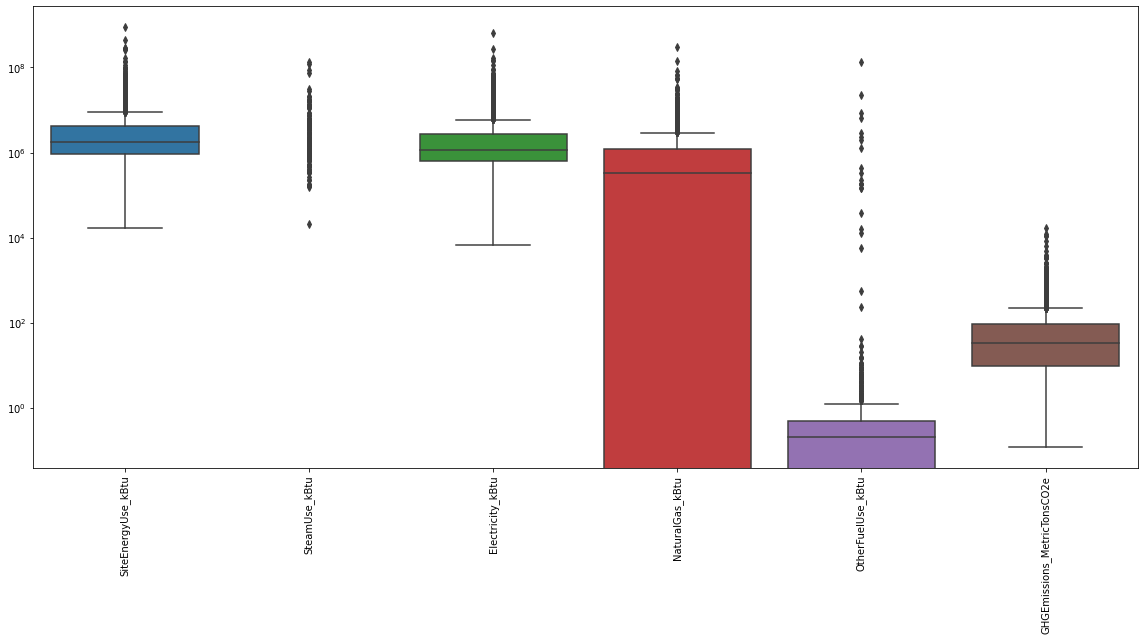

In [40]:
data = raw_data.loc[:, ['SiteEnergyUse_kBtu',
        'SteamUse_kBtu','Electricity_kBtu', 'NaturalGas_kBtu',
       'OtherFuelUse_kBtu', 'GHGEmissions_MetricTonsCO2e']]

f, ax = plt.subplots(figsize = (16, 9))


ax1 = sns.boxplot(data = data,ax=ax)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax.set(yscale="log")

            
plt.tight_layout()

In [41]:
raw_data = raw_data.drop(['PropertyName', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes',
                         'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'], axis = 1)

Nous allons supprimer les variables qualitatives ayant trop de modalités

In [42]:
raw_data.loc[raw_data["NumberofBuildings"]==0, "NumberofBuildings"] = 1

On remplace les bâtiments qui ont "NumberOfBuildings" à 0 par 1

In [43]:
raw_data[raw_data["SiteEnergyUse_kBtu"] ==0.0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI_kBtu_sf,SiteEUIWN_kBtu_sf,SourceEUI_kBtu_sf,SourceEUIWN_kBtu_sf,SiteEnergyUse_kBtu,SiteEnergyUseWN_kBtu,SteamUse_kBtu,Electricity_kWh,Electricity_kBtu,NaturalGas_therms,NaturalGas_kBtu,OtherFuelUse_kBtu,GHGEmissions_MetricTonsCO2e,GHGEmissionsIntensity_kgCO2e_ft2,DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude


Aucune ligne sans consommation.

In [44]:
raw_data['LargestPropertyUseTypeGFA'] = raw_data['LargestPropertyUseTypeGFA'].fillna(raw_data['PropertyGFATotal'])
raw_data['SecondLargestPropertyUseTypeGFA'] = raw_data['SecondLargestPropertyUseTypeGFA'].fillna(0)
raw_data['ThirdLargestPropertyUseTypeGFA'] = raw_data['ThirdLargestPropertyUseTypeGFA'].fillna(0)

In [45]:
mask = raw_data['GHGEmissionsIntensity_kgCO2e_ft2'] - round((raw_data['GHGEmissions_MetricTonsCO2e']*1000) / raw_data['PropertyGFATotal'], 2) ==0
raw_data = raw_data[mask]

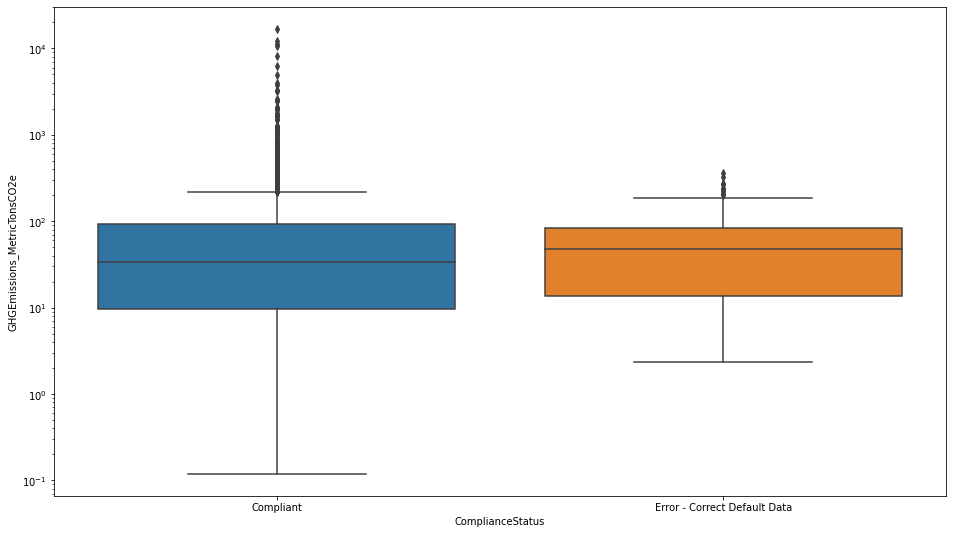

In [46]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set(yscale="log")
sns.boxplot(data = raw_data, y= "GHGEmissions_MetricTonsCO2e", x="ComplianceStatus")
plt.show()

In [55]:
raw_data = raw_data[raw_data['ComplianceStatus'] == "Compliant"]

Malgré que les données en erreur corrigées par des données par défaut semble s'intégrer aux autres données sans changer la distribution, nous ne garderons que les données compliant afin d'avoir un jeu sans biais dû à des corrections faites par défaut.

## [ANALYSE DES CORRELATIONS POUR SELECTION DES VARIABLES](#sommaire)<a class="anchor" id="9"></a>

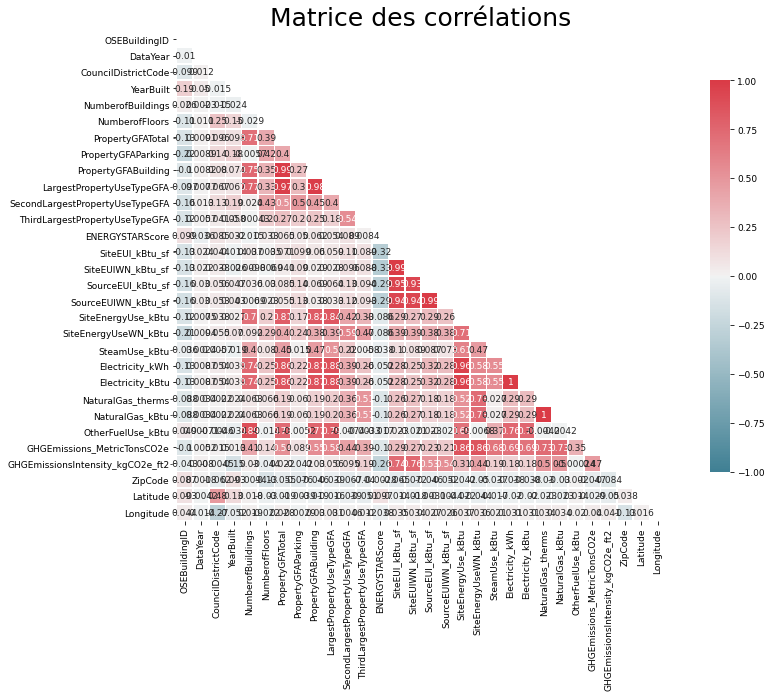

In [56]:
matrice_correlation = raw_data.loc[:,raw_data.select_dtypes(include=[np.number]).columns.values]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 9}

plt.rc('font', **font)

# Compute the correlation matrix
corr = matrice_correlation.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot = True, ax = ax).set_title("Matrice des corrélations", size = 25)

plt.draw()

<p>Matrice de corrélation :
    <ul>
        <li>Corrélation de 1 : Electricity_kWh et Electricity_kBtu, on ne conserve que la mesure en kBtu</li>
        <li>Corrélation de 1 : NaturalGas_therm et NaturalGas_kBtu, on ne conserve que la mesure en kBtu</li>
        <li>SiteEnergyUse_kBtu corrélée avec :
            <ul>
                <li>NumberOfBuildings</li>
                <li>PropertyGFATotal</li>
                <li>PropertyGFABuilding</li>
                <li>LargestPropertyUseTypeGFA</li>
                <li>SecondPropertyUseTypeGFA</li>
                <li>ThirdPropertyUseTypeGFA</li>
            </ul>
        </li>
        <li>Electricity_kBtu corrélée avec :
            <ul>
                <li>NumberOfBuildings</li>
                <li>PropertyGFATotal</li>
                <li>PropertyGFABuilding</li>
                <li>LargestPropertyUseTypeGFA</li>
                <li>SecondPropertyUseTypeGFA</li>
                <li>ThirdPropertyUseTypeGFA</li>
            </ul>
        </li>
        <li>NaturalGas_kBtu corrélée avec :
            <ul>
                <li>SecondPropertyUseTypeGFA</li>
                <li>ThirdPropertyUseTypeGFA</li>
            </ul>
        </li>
        <li>SteamUse_kBtu corrélée avec :
            <ul>
                <li>NumberOfBuildings</li>
                <li>PropertyGFABuilding</li>
                <li>LargestPropertyUseTypeGFA</li>
            </ul>
        </li>
        <li>OtherFuelUse_kBtu corrélée avec :
            <ul>
                <li>NumberOfBuildings</li>
                <li>PropertyGFATotal</li>
                <li>PropertyGFABuilding</li>
                <li>LargestPropertyUseTypeGFA</li>
            </ul>
        </li>
    </ul>
</p>

Nous refaisons une matrice des corrélations épurée ne conservant que les variables ayant une corrélation avec nos variables target.

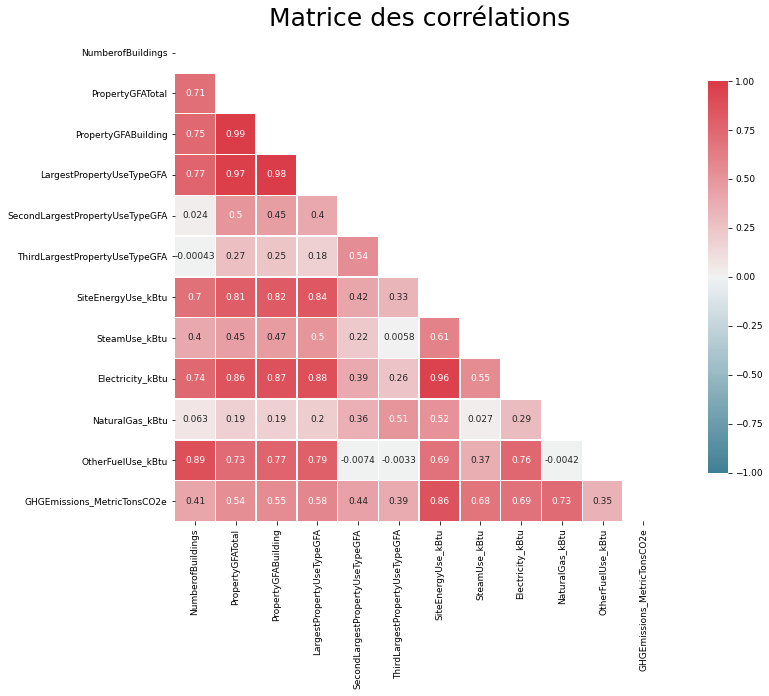

In [62]:
matrice_correlation = raw_data.loc[:,['NumberofBuildings',
       'PropertyGFATotal', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse_kBtu', 'SteamUse_kBtu',
       'Electricity_kBtu', 'NaturalGas_kBtu','OtherFuelUse_kBtu', 'GHGEmissions_MetricTonsCO2e']]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 9}

plt.rc('font', **font)

# Compute the correlation matrix
corr = matrice_correlation.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot = True, ax = ax).set_title("Matrice des corrélations", size = 25)

plt.draw()

## [FINALISATION DATASET NETTOYER](#sommaire)<a class="anchor" id="10"></a>

In [ ]:
raw_data.columns

In [ ]:
raw_data = raw_data.drop(['DataYear', 'CouncilDistrictCode', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
              'SiteEUI_kBtu_sf', 'SiteEUIWN_kBtu_sf', 'SourceEUI_kBtu_sf', 'SourceEUIWN_kBtu_sf',
              'SiteEnergyUseWN_kBtu', 'Electricity_kWh', 'NaturalGas_therms', 'DefaultData', 'ComplianceStatus',
       'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude'], axis = 1)

In [ ]:
raw_data.to_csv("DATA/clean_data.csv")